In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as stats
import pymc3 as pm
import pandas as pd
import seaborn as sns
import arviz as az

# Statistical Rethinking

This notebook is for personal use by me to illustrate and the principles and concepts outlined in the book $\textit{statistical rethinking}$ by Richard McElreath. The book is meant to be done in R, but I prefer python, so I will be converting the relavent and interesting bits of code into python here. This will also be making use of tools for Bayesian statistical inference in python. The package pymc3 will be used for this, and the book $\textit{Bayesian analysis with python}$ by Osvaldo Martin will be used as crutch for learning pymc3 on the fly.

# Chapter 2 

### Grid approximation of the posterior distribution.

In the chaper McElreath outlines the formation formation of a posterior distribution using a grid approximation. Succinctly, this can be thought of as follows: Computers can't actually represent continuous distributions so we discretise our conitnuous functions in order to approximate them such that the computer can actually work with them. This is relevant to Bayesian inference in the following way. We may have some posterior distribution over a parameter, given the data $P(p|D)$. We can compute this function at any particular point $p'$. If we compute the prior of a discrete grid of values, we can obtain a good approximation to what is actually a continuous function. We can easily do this using the tools of numpy to define our grid of values and then perform the computations.

In his book he attempts to approximate the percentage of the Earth's surface covered in water by throwing the globe in the air and asking whether the throwers index finger lands on Water, W, or Land, L. If the p is the fraction of the Earths surface covered in water, then we would like to know p. The looklihood model that this corresponds to is the binomial model

$Pr(W,L|p) = {W+L \choose W} p^W(1-p)^L$

Where W is the number of times water comes up and the L is the number of times land comes up. We place a uniform prior distribution over the range of paramter values for p. This gives

$Pr(p|W,L) \propto Pr(W,L|p)Pr(p)$

where we just need to ensure that normalisation takes place. With the grid method we can compute the approximation to the posterior with the following code. (we piggy back on pre-implemented computations of the likelihood using scipy). We assume we have observed water 6 times and land 3 times in the computation. We will also plot for different numbers of grid points to show how the appriximation improves with the number of grid squares.

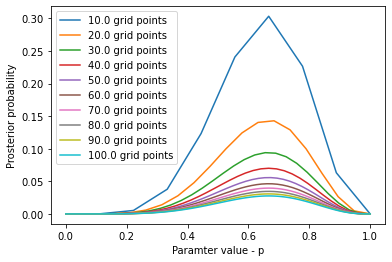

In [2]:
for n in np.linspace(10,100,10):
    #get the grid of parameter values
    p = np.linspace(0,1,int(n))
    #compute the likelihood for each value of p, assuming 6 success and 3 fails
    likelihood = stats.binom.pmf(k =6, n=9,p= p)
    #prior is unif(0,1)
    prior = 1
    #posterior
    post = likelihood*prior
    #normalise the posterior
    post = post/np.sum(post)
    plt.plot(p,post, label = str(n) + " grid points")
    
plt.xlabel("Paramter value - p")
plt.ylabel("Prosterior probability")
plt.legend()
plt.show()

Clearly as there are more and more grid points, the grid approximation becomes a better and better representation of the posterior distribution. The curves appear to have a smaller and smaller area, which would violate the normalisation of property of probability functions. But note here, that in the grid approximation we are assigning probabilities to exact values of p, and as the grid points grow, the more accurately this will represent and continuous pdf. But in the low n limit, far more probability mass is assigned to exact positions, rather than a density over a range of values. So all are valid probabilities, but the low n limit is a poor approximation to the actual continuous posterior distribution.

We can easily reimplement the above code to see the effects of a different prior, eg a step function

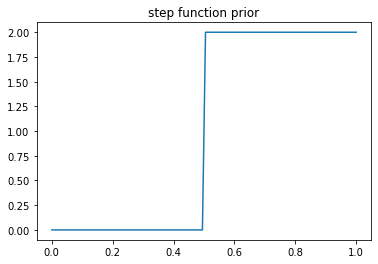

In [3]:
plt.plot(p,np.heaviside(p-0.5, 0.5)*2)
plt.title("step function prior")
plt.show()

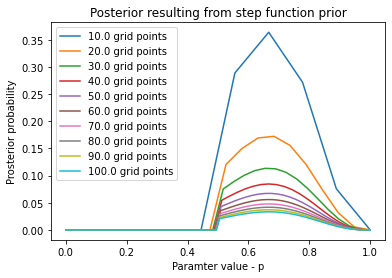

In [7]:
for n in np.linspace(10,100,10):
    #get the grid of parameter values
    p = np.linspace(0,1,int(n))
    #compute the likelihood for each value of p, assuming 6 success and 3 fails
    likelihood = stats.binom.pmf(k =6, n=9,p= p)
    #prior is heaviside step function around 
    prior = np.heaviside(p-0.5, 0.5)*2
    #posterior
    post = likelihood*prior
    #normalise the posterior
    post = post/np.sum(post)
    plt.plot(p,post, label = str(n) + " grid points")
    
plt.xlabel("Paramter value - p")
plt.ylabel("Prosterior probability")
plt.legend()
plt.title("Posterior resulting from step function prior")
plt.show()

In [8]:
np.sum(post)

0.9999999999999998

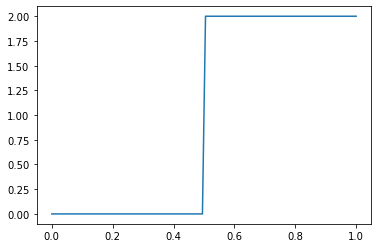

In [9]:
plt.plot(p,np.heaviside(p-0.5, 0.5)*2)

## Laplaces Approximation

In the next part of the chapter, McElreath implements the "quadratic approximation" otherwise referred to as $\textit{Laplace's Method}$. The general thrust of this approach is that many probability distributions look kind of bell curvy, therefore why not approximate it them with The Bell Curve/Normal distribution. In the context of Bayesian inference, one can approximate the prior distribution with the normal approximation. One simply sets the mean of the normal approximation to be at the mode of the distribution you're trying to approximate, and the standard deviation to be 1/curvature at the mode. Without going into (and skipping quite a bit of) detail, this last point makes intuitive sense. If the distribution you're trying to approximate is narrow, it will have a sharp peak with a lot of curvature, but you'll want to approximate it with a narrow gaussian, which corresponds to one with a small standard deviation. The normal approximation can be implemented with pymc3 as follows.

In [10]:
"""Obtain the posterior distribution using pymc3

Then use it to find the maximum and curvature of the distribution and plot this
"""
#define the data for getting 6 W oberved and 3 L
data = np.append(np.ones(6), np.zeros(3))
with pm.Model() as our_first_model:
    #define the prior
    p = pm.Uniform('p')
    #define the likelihood
    y = pm.Bernoulli('y', p=p, observed=data)
    #
    approx_mean = pm.find_MAP()
    approx_std = ((1/pm.find_hessian(approx_mean, vars=[p]))**0.5)[0]

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '367' (I am process '1482')


In [11]:
approx_mean["p"]

array(0.66666667)

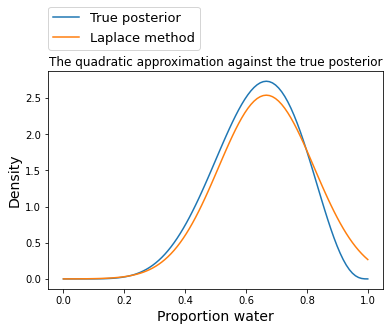

In [12]:
#plot the gaussian approximation to the posterio against the true posterior beta posterior
w, n = 6, 9
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x , w+1, n-w+1),
         label='True posterior')
plt.plot(x, stats.norm.pdf(x, approx_mean["p"], approx_std),
         label='Laplace method')

plt.legend(loc=(0,1.1), fontsize=13)
plt.title("The quadratic approximation against the true posterior")
plt.xlabel('Proportion water', fontsize=14)
plt.ylabel('Density', fontsize=14);

## End of chapter problems

2E1) $\textit{the probability of rain on Monday?}$ can be expressed as 

   (2) $Pr(rain|Monday)$
    
2E2) Pr(Monday|rain) corresponds to?

   (3)  The probability that it is Monday, given that it is raining.
    
2E3) $\textit{the probability that it is Monday, given that it is raining?}$ is equivalent to 

   (1) $Pr(Monday|rain)$
   (3) $\frac{Pr(rain|Monday)Pr(Monday)}{Pr(rain)}$
   
2E4) A fairly philosophical question.

   To say that the probability of something is p=x, is to state our belief about the situation, not to claim that it is objectively the case. So saying the Earth has probability 0.7 that any randomly sample point on its surface will be water is something akin to revealing you believe that around 0.7 of the Earth's surface is covered, but your belief could change in light of new data that you recieve upon further sampling

2M1) Recall the globe tossing model from the chapter. Compute and plot the grid approximate
posterior distribution for each of the following sets of observations. In each case, assume a uniform
prior for p.
(1) W, W, W
(2) W, W, W, L
(3) L, W, W, L, W, W, W

In [13]:
#express the above scenarios as the number of waters in each
W = np.array([3,3,5])
#give the total number of trials
Total = np.array([3,4,7])

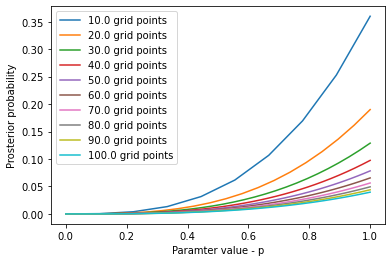

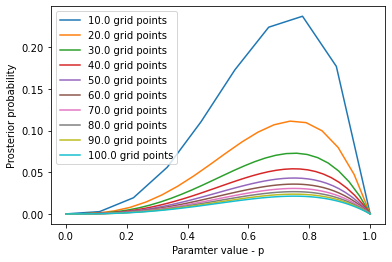

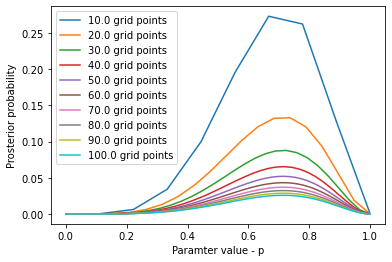

In [14]:
#Get the plots for each scenario, trying different numbers of grid points for each
for i,j in zip(W,Total):
    for n in np.linspace(10,100,10):
        #get the grid of parameter values
        p = np.linspace(0,1,int(n))
        #compute the likelihood for each value of p, assuming 6 success and 3 fails
        likelihood = stats.binom.pmf(k =i, n=j,p= p)
        #prior is unif(0,1)
        prior = 1
        #posterior
        post = likelihood*prior
        #normalise the posterior
        post = post/np.sum(post)
        plt.plot(p,post, label = str(n) + " grid points")

    plt.xlabel("Paramter value - p")
    plt.ylabel("Prosterior probability")
    plt.legend()
    plt.show()

2M2. Now assume a prior for p that is equal to zero when p < 0.5 and is a positive constant when
p ≥ 0.5. Again compute and plot the grid approximate posterior distribution for each of the sets of
observations in the problem just above.

To do this I'll just recycle the code I used above, but I'll modify the prior from being the uniform distribution to become the Heaviside function $\theta(x-0.5)$

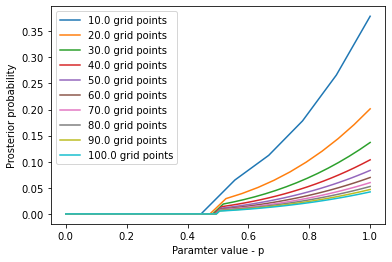

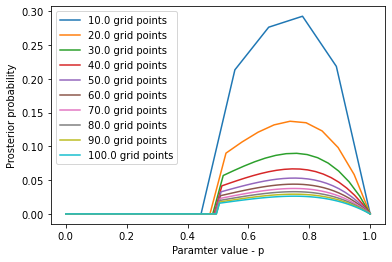

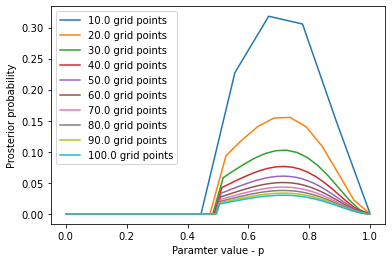

In [15]:
#Get the plots for each scenario, trying different numbers of grid points for each
for i,j in zip(W,Total):
    for n in np.linspace(10,100,10):
        #get the grid of parameter values
        p = np.linspace(0,1,int(n))
        #compute the likelihood for each value of p, assuming 6 success and 3 fails
        likelihood = stats.binom.pmf(k =i, n=j,p= p)
        #prior is step function
        prior = np.heaviside(p-0.5, 0.5)*2
        #posterior
        post = likelihood*prior
        #normalise the posterior
        post = post/np.sum(post)
        plt.plot(p,post, label = str(n) + " grid points")

    plt.xlabel("Paramter value - p")
    plt.ylabel("Prosterior probability")
    plt.legend()
    plt.show()

2M3. Suppose there are two globes, one for Earth and one for Mars. The Earth globe is 70% covered
in water. The Mars globe is 100% land. Further suppose that one of these globes—you don’t know
which—was tossed in the air and produced a “land” observation. Assume that each globe was equally
likely to be tossed. Show that the posterior probability that the globe was the Earth, conditional on
seeing “land” (Pr(Earth|land)), is 0.23.

This is a straight forward Bayesian inference question along the following lines

$Pr(E|L) = \frac{Pr(L|E)Pr(E)}{Pr(L)} = \frac{Pr(L|E)Pr(E)}{Pr(L|E)Pr(E) + Pr(L|M)Pr(M)} = \frac{Pr(L|E)}{Pr(L|E) + Pr(L|M)} = \frac{0.3}{1+0.3} = 0.23...$

where I have used the fact that the Pr(E)=Pr(M) and Pr(L|E) = 1 - Pr(W|E) = 1 - 0.7 = 0.3

2M4. Suppose you have a deck with only three cards. Each card has two sides, and each side is either
black or white. One card has two black sides. The second card has one black and one white side. The
third card has two white sides. Now suppose all three cards are placed in a bag and shuffled. Someone
reaches into the bag and pulls out a card and places it flat on a table. A black side is shown facing up,
but you don’t know the color of the side facing down. Show that the probability that the other side is
also black is 2/3. Use the counting method (Section 2 of the chapter) to approach this problem. This
means counting up the ways that each card could produce the observed data (a black side facing up
on the table).

Another rudimentary application of Bayes' theorem. Call DB:= you picked a double black card, B:= Observed a black face, then

$Pr(DB|B) = \frac{Pr(B|DB)Pr(DB)}{Pr(B)} = \frac{(1)(1/3)}{1/2} = 2/3$

Pr(B) = 1/2 as half that you might pick are indeed black

Pr(DB|B) = 1 as if you pick the double black card, you have to see a black face

Pr(DB) = 1/3 as there are 3 possible cards you might choose

2M5. Now suppose there are four cards: B/B, B/W, W/W, and another B/B. Again suppose a card is
drawn from the bag and a black side appears face up. Again calculate the probability that the other
side is black.

The probability that the other side is black is the same as the probability that you picked a double black card, given that you saw a black face. We can reapply Bayes' theorem with updated values

$Pr(DB|B) = \frac{Pr(B|DB)Pr(DB)}{Pr(B)} = \frac{(1)(1/2)}{5/8} = 4/5$

as 4/5 of the faces are black and you have a 50-50 chance of picking a double black card in this set-up

2M6. Imagine that black ink is heavy, and so cards with black sides are heavier than cards with white
sides. As a result, it’s less likely that a card with black sides is pulled from the bag. So again assume
there are three cards: B/B, B/W, and W/W. After experimenting a number of times, you conclude that
for every way to pull the B/B card from the bag, there are 2 ways to pull the B/W card and 3 ways to
pull the W/W card. Again suppose that a card is pulled and a black side appears face up. Show that
the probability the other side is black is now 0.5. Use the counting method, as before.


To make this clearer, this is equivalent to setting a new prior distribution on the set of cards that you have. They are as follows. 

$Pr(B/B) = \frac{1}{1+2+3}$

$Pr(B/W) = \frac{2}{1+2+3}$

$Pr(W/W) = \frac{3}{1+2+3}$

Then we can see that this implies the following

$Pr(B) = Pr(B|B/B)Pr(B/B) + Pr(B|B/W)Pr(B/W) + Pr(B|W/W)Pr(W/W) = 1 \times 1/6 + 1/2 \times 2/6 + 0 \times1/2 = 1/3$

Giving the final result to be

$Pr(DB|B) = \frac{Pr(B|DB)Pr(DB)}{Pr(B)} =  \frac{1 \times 1/6}{1/3} = 1/2$

QED

2M7. Assume again the original card problem, with a single card showing a black side face up. Before
looking at the other side, we draw another card from the bag and lay it face up on the table. The face
that is shown on the new card is white. Show that the probability that the first card, the one showing
a black side, has black on its other side is now 0.75. Use the counting method, if you can. Hint: Treat
this like the sequence of globe tosses, counting all the ways to see each observation, for each possible
first card.

We can solve this as follows. Let B/B be the event that the first card picked was double black and B/W be the event that the first card picked was the Black and white mixed card. Now let $B_1$ and $W_2$ be the observations that the face observed on the first card was black and the face observed on the second was white. We can apply Bayes' theorem in the usual manner

$Pr(B/B) = \frac{Pr(B_1,W_2|B/B)Pr(B/B)}{Pr(B_1,W_2)}$

Using the law total probability and the properties of conditional probabilities we can find the denominator with the following

$Pr(B_1,W_2) = Pr(B_1,W_2|B/B)Pr(B/B) + Pr(B_1,W_2|B/W)Pr(B/W)$

(We can ignore conditioning on the W/W event, as it's impossible to observe a black face if this was the first card you picked)

$ = Pr(W_2|B_1,B/B)Pr(B_1|B/B)Pr(B/B) + Pr(W_2|B_1,B/W)Pr(B_1|B/W)Pr(B/W)$

$ = 3/4 \times 1 \times 1/3 + 1/2 \times 1/2 \times 1/3$

$ Pr(B_1,W_2) = 1/3$

Plugging in, we get 

$\frac{Pr(B_1,W_2|B/B)Pr(B/B)}{Pr(B_1,W_2)} = \frac{3/4 \times 1/3}{1/3} = 3/4$

QED

2H1. Suppose there are two species of panda bear. Both are equally common in the wild and live
in the same places. They look exactly alike and eat the same food, and there is yet no genetic assay
capable of telling them apart. They differ however in their family sizes. Species A gives birth to twins
10% of the time, otherwise birthing a single infant. Species B births twins 20% of the time, otherwise
birthing singleton infants. Assume these numbers are known with certainty, from many years of field
research.
Now suppose you are managing a captive panda breeding program. You have a new female panda
of unknown species, and she has just given birth to twins. What is the probability that her next birth
will also be twins?

As we have asolutely no reason to prefer one species over the other, we should choose to use a uniform prior over the data.
Let $T_1$ denote the first offspring were twins. Let A and B denote the panda being from species A and B respectively. Using this in Bayes' theorem we get

$Pr(A|T_1) = \frac{Pr(T_1|A)Pr(A)}{Pr(T_1)} = \frac{Pr(T_1|A)Pr(A)}{Pr(T_1|B)Pr(B) + Pr(T_1|A)Pr(A)} = \frac{Pr(T_1|A)}{Pr(T_1|B) + Pr(T_1|A)} = \frac{0.1}{0.2+0.1} = 1/3$

Which implies 

$Pr(B|T_1) = 1 - Pr(A|T_1) = 2/3$

This all fits in nicely with McElreath's notion of the proportion of the forking garden paths which produce the data given by a hypothesis is the appropriate posterior probability. Why? Because in this case, if 10% of species A produces twins and 20% of species B produce twins, and both species are in all other ways indistringuishable, then it makes intuitive sense that 1/3 and 2/3 of all twins observations are attributable to species A and B respectively. This fits our intuitions of assigning probability in accordance to the frequency of the hypotheses producing the data.

To predict the next set of offspring this panda will produce, we compute the probability of producing twins in each species, weighted by the posterior probability of being from each species.

$Pr(T_2|T_1) = Pr(T_2|A,T_1)Pr(A|T_1) + Pr(T_2|B,T_1)Pr(B|T_1) = 0.1 \times 1/3 + 0.2 \times 2/3 = 1/6$

As we can see, the evidence from the twins in the first generation has increased our likelihood of observing twins in the second generation when we incorporate the evidivence appropriately. Before we knew about the first generation, we would have said the probability of twins was about $0.1 \times 1/2 + 0.2 \times 1/2 = 3/20$ As we can see, the evidence has increased the probability we assigned to the next obserbation being twins.

2H3. Continuing on from the previous problem, suppose the same panda mother has a second birth
and that it is not twins, but a singleton infant. Compute the posterior probability that this panda is
species A

We can just plug all the data into Bayes' theorem in one go:

$Pr(A|S_2,T_1) = \frac{Pr(S_2,T_1|A)Pr(A)}{Pr(S_2,T_1|A)Pr(A) + Pr(S_2,T_1|B)Pr(B)} = \frac{Pr(S_2,T_1|A)}{Pr(S_2,T_1|A) + Pr(S_2,T_1|B)} = \frac{0.1 \times 0.9}{0.1 \times 0.9 + 0.2 \times 0.8} = 0.36$

This implies that the species B is more informed. This might seem like quite a large skew to the posterior probabilites given the data. However, any twins observation is much more overwhelming evidence for species B than any singles observation is evidence for species A. Hence the fact that half our observations so far we twins is still strong evidence that this panda was from species B.

2H4. A common boast of Bayesian statisticians is that Bayesian inference makes it easy to use all of
the data, even if the data are of different types.
So suppose now that a veterinarian comes along who has a new genetic test that she claims can
identify the species of our mother panda. But the test, like all tests, is imperfect. This is the information you have about the test:
• The probability it correctly identifies a species A panda is 0.8.
• The probability it correctly identifies a species B panda is 0.65.
The vet administers the test to your panda and tells you that the test is positive for species A. First
ignore your previous information from the births and compute the posterior probability that your
panda is species A. Then redo your calculation, now using the birth data as well.

Given only the test data we can write $Test_A$ to indicate the test results said species A. Deploying Bayes' theorem we find that $Pr(A|Test_A) = \frac{Pr(Test_A|A)Pr(A)}{Pr(Test_A)} = \frac{Pr(Test_A|A)Pr(A)}{Pr(Test_A|A)Pr(A) + Pr(Test_A|B)Pr(B)} $

Using a standard property of conidtional probabilities $Pr(Test_A|B) = 1 - Pr(Test_B|B) = 1 - 0.65 = 0.35$. This is the probaility that the test was wrong given that the species was actually B. As we have a uniform prior, we now find that:

$ = \frac{Pr(Test_A|A)Pr(A)}{Pr(Test_A|A)Pr(A) + Pr(Test_A|B)Pr(B)} =  \frac{Pr(Test_A|A)}{Pr(Test_A|A) + Pr(Test_A|B)} = \frac{0.8}{0.8+ 0.35} = 0.72$ 

That is, testing positive for A would constitute reasonable evidence for the bear being of species A.

If we incorporate all of the data into this Bayesian update, we can do it all in one go. We need the likelihood of observing the data, which I'll denote short hand by $D = Test_A,T_1,S_2$. The likelihood of each of these data points is independent from one another so we find that

$Pr(A|D) = \frac{Pr(D|A)}{Pr(D|A) + Pr(D|B)} = \frac{0.8 \times 0.1 \times 0.9}{0.8 \times 0.1 \times 0.9 + 0.35 \times 0.2 \times 0.8} = 0.5625$

When all of the data is incorporated, then we see that it's much nearer to 50-50. This is because the twin data points away from species A, whilst the Test data points in favour of species A, counteracting to a large degree, so the combined data is more ambigious.

The way I computed the bayesian update in the step above was to compute the likelihood for the data all in one go. However, I have the posterior distribution given the birth data. I should be able to use the posterior from the birthdata as my prior for the test data and get the same result as combining everything in one go. Lets check to see that this is write:

Our prior with the birth data would be Pr(A) = 0.36, Pr(B) = 0.64 from my solution to 2H3. Setting this as the prior in our Bayesian update for the test data gives that $Pr(A|Test_A) = \frac{Pr(Test_A|A)Pr(A)}{Pr(Test_A|A)Pr(A) + Pr(Test_A|B)Pr(B)} = \frac{0.8 \times 0.36}{0.8 \times 0.36 + 0.35 \times 0.64} = 0.5625$

Nicely, everything is in agreement. We can perform our Bayesian updates in one step or by using our earlier posteriors as our new priors. We can show these are mathematically equivalent. Let's assume we used the earlier posterior as our new prior. Then we could write $A' = A|S_2,T_1$. Then using our posterior as prior, we write the final update step as 

$Pr(A'|Test_A) = \frac{Pr(Test_A|A')Pr(A')}{Pr(Test_A)} $

which is equivalent to

$Pr(A|S_2,T_1,Test_A) = \frac{Pr(Test_A \cap A')}{Pr(Test_A)} =  \frac{Pr(Test_A \cap A,S_2,T_1)}{Pr(Test_A)} $